# Student ID: 2412204

*   **Name**: Thuan Anh Bui
*   **Username**: tb24600

Code sections:

1.   Common Codes
2.   Method/model 1 Specific Codes
3.   Method/model 2 Specific Codes
4.   Other Method/model Codes, if any

**You must have `train_1`, `test_1` for   and `train_2`, `test_2` for training and testing. This will be evaluated automatically, without this your code will fail and no marked.**








Let's install all require libraries. For example, `transformers`

In [1]:
!pip install transformers
!pip install spacy

Let's import all required libraries.
For example, `numpy`

In [2]:
import os, pickle, re, html, spacy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import torch
from torch.utils.data import DataLoader, TensorDataset

from transformers import BertTokenizer

In [3]:
print(torch.__version__)

2.9.0+cpu


In [4]:
student_id = 2412204

In [5]:
# set same seeds for all libraries

#numpy seed
np.random.seed(student_id)

train_1()
test_1()
train_2()
test_2()

# 1 . Common Codes

In this section you will write all common codes, for examples


*   Data read
*   Command Line argument reading
*   Performance Matrics
*   Print Dataset Statistics
*   Saving model and output
*   Loading Model and output
*   etc




In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [7]:
# Add your code to initialize GDrive and data and models paths
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = './CE807-25-SU/Assignment/'
GOOGLE_DRIVE_PATH = os.path.join('gdrive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print('List files: ', os.listdir(GOOGLE_DRIVE_PATH))

List files:  ['data', 'model', 'code.ipynb']


In [8]:
DATA_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'data')
train_file = os.path.join(DATA_PATH, 'train.csv')
print('Train file: ', train_file)

val_file = os.path.join(DATA_PATH, 'valid.csv')
print('Validation file: ', val_file)

test_file = os.path.join(DATA_PATH, 'test.csv')
print('Test file: ', test_file)

Train file:  gdrive/MyDrive/./CE807-25-SU/Assignment/data/train.csv
Validation file:  gdrive/MyDrive/./CE807-25-SU/Assignment/data/valid.csv
Test file:  gdrive/MyDrive/./CE807-25-SU/Assignment/data/test.csv


In [9]:
# Read Train Data
train_df = pd.read_csv(train_file)
train_df.head()

,id,data_id,text,rating
0,91204,42,This is a taste an odor filter. The GE does ta...,1
1,149604,42,This pitcher is a good size for home use. We t...,5
2,449032,42,"The adapters keep falling off, I may have to g...",2
3,340902,42,Only complaint is where the plug sits on this ...,3
4,257157,42,This portable washer is so convenient if you l...,5


In [10]:
# Read Validation Data
val_df = pd.read_csv(val_file)
val_df.head()

,id,data_id,text,rating
0,486996,42,These work well and were very easy to purchase...,5
1,240190,42,I had this on a trawler for 8 years. Sold the...,5
2,130275,42,Replacement wheels worked great... just what w...,5
3,321957,42,After looking for through many other pumps I d...,5
4,382878,42,"Found them, ordered them, received them ... fa...",5


In [11]:
# Read Test Data
test_df = pd.read_csv(test_file)
test_df.head()

,id,data_id,text,out_label_model_1,out_label_model_2
0,546063,42,a tad too small where the water lines connect....,5,1
1,115749,42,it was easy to make my dishwasher look new again!,5,5
2,175693,42,"the part was new, fast shipping, fixed the iss...",5,5
3,12574,42,not the right one for my refrigerator,5,5
4,44665,42,exact the same as the old one.,5,5


In [12]:
# Taken from Lab 09
def read_data(file_name):
  df = pd.read_csv(file_name)
  print(file_name, 'has', len(df),'data points')
  return df

In [35]:
test_df = read_data(test_file)

gdrive/MyDrive/./CE807-25-SU/Assignment/data/test.csv has 1386 data points


In [36]:
MODEL_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'model')
MODEL_1_DIRECTORY = os.path.join(MODEL_PATH, 'logistic_regression_spacy')
print('Model 1 directory: ', MODEL_1_DIRECTORY)

MODEL_2_DIRECTORY = os.path.join(MODEL_PATH, 'logistic_regression_bert')
print('Model 2 directory: ', MODEL_2_DIRECTORY)

os.makedirs(MODEL_1_DIRECTORY, exist_ok=True)
os.makedirs(MODEL_2_DIRECTORY, exist_ok=True)

Model 1 directory:  gdrive/MyDrive/./CE807-25-SU/Assignment/model/logistic_regression_spacy
Model 2 directory:  gdrive/MyDrive/./CE807-25-SU/Assignment/model/logistic_regression_bert


## 1.1. Plotting Table for Model Validation

> **Source**: The code for generating the table was adapted from *Dorian Lazar, "Simple Little Tables with Matplotlib,"* Medium, Oct. 10, 2018. Accessed on July 14, 2025.
>
> **Link**: [https://medium.com/data-science/simple-little-tables-with-matplotlib-9780ef5d0bc4](https://medium.com/data-science/simple-little-tables-with-matplotlib-9780ef5d0bc4).


In [37]:
def plot_table(df, title, styling_func, scale=(1.5, 1.6)):
    """
    A generic function to plot a DataFrame as a styled Matplotlib table.

    Args:
        df (pd.DataFrame): The data to display in the table.
        title (str): The title of the plot.
        styling_func (function): A function that takes (row, col, cell)
                                 and applies custom styles.
        scale (tuple): A tuple to scale the table's width and height.
    """
    # Table generation code adapted from: "Simple Little Tables with Matplotlib" by Dorian Lazar,
    # Medium, https://medium.com/data-science/simple-little-tables-with-matplotlib-9780ef5d0bc4
    # Accessed on July 14, 2025
    fig, ax = plt.subplots(figsize=(len(df.columns) * 1.3, len(df) * 0.6 + 1))
    ax.axis('off')
    ax.axis('tight')

    # Create the table
    table = ax.table(
        cellText=df.values,
        rowLabels=df.index,
        colLabels=df.columns,
        cellLoc='center',
        rowLoc='center',
        loc='center'
    )
    table.scale(scale[0], scale[1])

    # Apply the custom styling function passed as an argument
    for (row, col), cell in table.get_celld().items():
        styling_func(row, col, cell)

    # Display the table
    plt.tight_layout()
    plt.show()

## 1.2. Plotting Classification Report

> **Source**: The code for generating a Matplotlib table with highlights was adapted from "*Matplotlib Table Tutorial*" on Python Fiddle: [https://python-fiddle.com/tutorials/matplotlib-table](https://python-fiddle.com/tutorials/matplotlib-table). Accessed on July 17, 2025.

In [38]:
def plot_classification_report(report_df, title='Classification Report'):
    """
    Plots a classification report by defining its specific style
    and calling the generic plot_table function.
    """
    def style_report(row, col, cell):
        # Table with highlights adapted from:
        # "Matplotlib Table Tutorial", Python Fiddle
        # https://python-fiddle.com/tutorials/matplotlib-table
        # Accessed on July 17, 2025
        if row == 0:  # Header row
            cell.set_facecolor('#9df9fc')
            cell.set_text_props(weight='bold')
        elif col == -1:  # Row labels
            cell.set_facecolor('#bffdff')
            cell.set_text_props(weight='bold')
        else:
            cell.set_text_props(weight='normal')

    plot_table(report_df, title, style_report, scale=(1.2, 1.5))

def plot_confusion_matrix(cm_df, title='Confusion Matrix'):
    """
    Plots a confusion matrix by defining its specific style
    and calling the generic plot_table function.
    """
    def style_matrix(row, col, cell):
        # Table with highlights adapted from:
        # "Matplotlib Table Tutorial", Python Fiddle
        # https://python-fiddle.com/tutorials/matplotlib-table
        # Accessed on July 17, 2025
        if (row == 0) or (col == -1):  # Header row or row labels
            cell.set_facecolor('#bffdff')
            cell.set_text_props(weight='bold')
        else:
            cell.set_facecolor('#FFFFFF')
            cell.set_text_props(weight='normal')

    plot_table(cm_df, title, style_matrix, scale=(1.8, 1.8))

# 2 . Method 1

The standard ML pipeline

*   Data reading
*   Data clearning, if any
*   Convert data to vector/tokenization/vectorization
*   Model Declaration/Initialization/building
*   Training and validation of the model using training and validation dataset
*   Save the trained model
*   Load and Test the model on testing set
*   Save the output of the model


## 2.1. Custom Preprocessing + Tokenization

> **Source**: The *SpacyLemmaTfidfVectorizer(TfidfVectorizer)* class were adapted from *Lab03: The implementation of KMeans in scikit-learn* by *Dr. Ravi Shekhar* in *CE807-7-SU: Text Analytics*, School of Computer Science and Electronic Engineering, Essex University. Accessed on July 9, 2025.


In [39]:
# Your Code(s)
def preprocessing_stage(text):
    """
    Cleans and standardises a raw text string.

    Args:
        text (str): The raw input string to be processed.

    Returns:
        str: The cleaned and normalised text string.
    """
    # Convert HTML entities to their actual characters
    text = html.unescape(text)

    # Remove or replace HTML tags
    text = re.sub(r'<br\s*/?>', '\n', text)

    # Normalize repeated punctuation: ??, !!, ...
    text = re.sub(r'([!?.,:;])\1+', r'\1', text)

    # Normalize repeated hyphens to em dash
    text = re.sub(r'-{2,}', ' — ', text)

    # Remove extra spaces around punctuation
    text = re.sub(r'\s*([!?.,])\s*', r'\1 ', text)

    # Remove any duplicated spaces
    text = ' '.join(text.split())

    # Lowercasing
    text = text.lower()
    return text


# Code adapted from Lab03: The implementation of KMeans in scikit-learn, CE807-7-SU: Text Analytics,
# School of Computer Science and Electronic Engineering, Essex University.
# Original authors: Dr. Ravi Shekhar, 2024.
# Accessed on July 9, 2025
class SpacyLemmaTfidfVectorizer(TfidfVectorizer):
    """
    A custom TfidfVectorizer that uses spaCy for lemmatization.

    It overrides the default 'build_analyzer' method to create a
    pipeline that first cleans the text, then tokenizes it, and
    finally converts each token to its lemma using spaCy.
    """
    def build_analyzer(self):
        # Get the default analyzer from the parent class, which handles
        # tokenization and n-grams
        base_analyzer = super(SpacyLemmaTfidfVectorizer, self).build_analyzer()
        nlp = spacy.load("en_core_web_sm")

        # Define the new, enhanced analyzer function
        def analyzer(doc):
            # Perform initial cleaning and apply tokenization with the base analyzer
            tokens = base_analyzer(preprocessing_stage(doc))

            # Rejoin tokens and process with spaCy for accurate lemmatization
            joined_text = ' '.join(tokens)
            doc_spacy = nlp(joined_text)

            # Return the list of lemmas
            return [token.lemma_ for token in doc_spacy]

        return analyzer

## 2.2. Training Method 1 Code

> **Source**: The pipeline structure used was adapted from *Lab05: Text Classification Comparison* by *Dr. Ravi Shekhar* in *CE807-7-SU: Text Analytics*, School of Computer Science and Electronic Engineering, Essex University. Accessed on July 10, 2025.

In [40]:
# Your Code(s)
def train_1(train_file, val_file, model_dir):
    """
    Trains a text classification pipeline using Logistic Regression and TF-IDF features,
    evaluates it on a validation set, and saves the best-performing model.

    The function performs the following steps:
    1. Loads training and validation data from CSV files.
    2. Iteratively trains a text classification pipeline using different n-gram ranges.
    3. Evaluates each model on the validation data using accuracy.
    4. Selects and saves the model with the highest validation accuracy.
    5. Displays a confusion matrix and classification report for the best model.

    Args:
        train_file (str): Path to the training dataset CSV file.
        val_file (str): Path to the validation dataset CSV file.
        model_dir (str): Path to the directory where the best model will be saved
                         as 'model.sav'.

    Returns:
        pd.DataFrame: Classification report (as a DataFrame) of the best model
        evaluated on the validation set.

    Notes:
        - Uses a custom vectorizer `SpacyLemmaTfidfVectorizer` for lemmatized TF-IDF features.
        - Model performance is evaluated using accuracy, confusion matrix,
        and a detailed classification report.
    """
    # Read training and validation set data
    train_df = pd.read_csv(train_file)
    val_df = pd.read_csv(val_file)

    X_train = train_df["text"]
    X_val = val_df["text"]
    y_train = train_df["rating"]
    y_val = val_df["rating"]

    ngram_options = [(1, 2), (1, 3)]
    best_acc = 0.0
    best_pipeline = None

    for ngram_range in ngram_options:
        print(f'Training with ngram_range={ngram_range}')

        # Pipeline integrates both the vectorizer and ML model adapted from
        # Lab05: Text Classification Comparison, "CE807-7-SU: Text Analytics",
        # School of Computer Science and Electronic Engineering, Essex University
        # Original author: Dr. Ravi Shekhar, 2024
        # Accessed on July 10, 2025
        pipeline = Pipeline([
            ('vectorizer', SpacyLemmaTfidfVectorizer(
                stop_words='english',
                ngram_range=ngram_range
            )),
            ('classifier', LogisticRegression(
                max_iter=1000,
                random_state=student_id))
        ])

        # Train and validate the model
        pipeline.fit(X_train, y_train)
        y_preds = pipeline.predict(X_val)

        # Compute metrics
        val_acc = accuracy_score(y_val, y_preds)
        if val_acc > best_acc:
            best_acc = val_acc
            best_pipeline = pipeline

    # Select the model with the highest accuracy
    if best_pipeline:
        # Confusion Matrix
        print("\nDisplaying Confusion Matrix:")
        labels = sorted(y_val.unique())
        val_cm = confusion_matrix(y_val, y_preds)
        cm_df = pd.DataFrame(val_cm, index=labels, columns=labels)
        plot_confusion_matrix(cm_df)

        # Classification Report
        print("\nDisplaying Classification Report:")
        report_dict = classification_report(y_val, y_preds, output_dict=True)
        report_df = pd.DataFrame(report_dict).transpose().round(4)
        plot_classification_report(report_df)

        # Save the model
        model_file = os.path.join(model_dir, 'model.sav')
        pickle.dump(best_pipeline, open(model_file, 'wb'))
        print(f'\nBest model saved to {model_file} (accuracy={best_acc:.4f})')

    return report_df

Training with ngram_range=(1, 2)
Training with ngram_range=(1, 3)

Displaying Confusion Matrix:


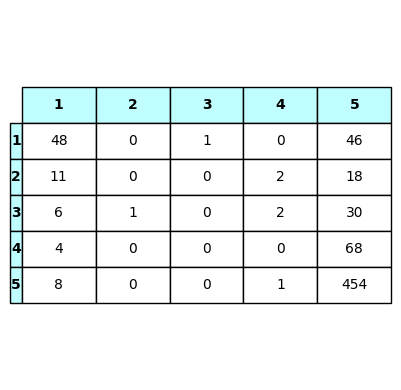


Displaying Classification Report:


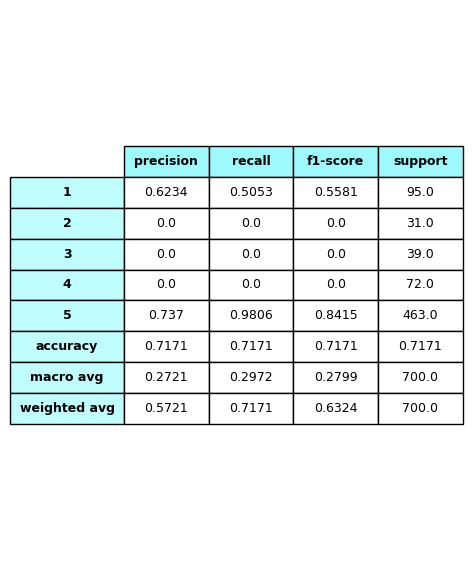


Best model saved to gdrive/MyDrive/./CE807-25-SU/Assignment/model/logistic_regression_spacy/model.sav (accuracy=0.7171)


In [41]:
report_1 = train_1(train_file, val_file, MODEL_1_DIRECTORY)

## 2.3. Testing Method 1 Code


In [42]:
# Your Code(s)
def test_1(test_file, model_file, output_dir):
    """
    Loads a saved text classification model, predicts labels for a test dataset,
    and saves the predictions back into the original test CSV file.

    Args:
        test_file (str): Path to the test dataset CSV file.
        model_file (str): Filename of the serialized (pickled) model to load
                          (e.g., 'model.sav').
        output_dir (str): Directory path where the model file is located.

    Returns:
        None

    Notes:
        - Predictions are stored in a new column called 'out_label_model_1'.
        - The updated CSV file will overwrite the original test file.
    """
    # Read testing set data
    test_df = pd.read_csv(test_file)

    # Load the model
    model_path = os.path.join(output_dir, model_file)
    classifier = pickle.load(open(model_path, 'rb'))
    print('Model loaded from', model_path)

    # Test the model on the testing set
    print('Testing on testing set')
    test_preds = classifier.predict(test_df['text'])
    print('Done testing')

    # Save predictions to the same directory as the model
    output_path = os.path.join(os.path.dirname(model_path), 'test_1_output.csv')
    pd.DataFrame({'out_label_model_1': test_preds}).to_csv(output_path, index=False)
    print('Predictions saved to', output_path)

    # Prediction outputs are updated to the testing set
    test_df['out_label_model_1'] = test_preds
    test_df.to_csv(test_file, index=False)
    print('Predictions added/updated to', test_file)

In [43]:
test_1(test_file, 'model.sav', MODEL_1_DIRECTORY)

Model loaded from gdrive/MyDrive/./CE807-25-SU/Assignment/model/logistic_regression_spacy/model.sav
Testing on testing set
Done testing
Predictions saved to gdrive/MyDrive/./CE807-25-SU/Assignment/model/logistic_regression_spacy/test_1_output.csv
Predictions added/updated to gdrive/MyDrive/./CE807-25-SU/Assignment/data/test.csv


## Method 1 End


# 3 . Method 2

The standard ML pipeline

*   Data reading
*   Data clearning, if any
*   Convert data to vector/tokenization/vectorization
*   Model Declaration/Initialization/building
*   Training and validation of the model using training and validation dataset
*   Save the trained model
*   Load and Test the model on testing set
*   Save the output of the model


## 3.1. BERT Tokenization

> **Source**: Code in *tokenize* function were adapted from "*Tokenizations*" by Nandan Nanda, Medium. Accessed on July 11, 2025. **Link**: [https://medium.com/@nandannanda01/tokenizations-65908744f96c](https://medium.com/@nandannanda01/tokenizations-65908744f96c)

> **Source**: The pipeline structure used was adapted from *Lab05: Text Classification Comparison* by *Dr. Ravi Shekhar* in *CE807-7-SU: Text Analytics*, School of Computer Science and Electronic Engineering, Essex University. Accessed on July 11, 2025.


In [44]:
# Your Code(s)
def tokenize(texts, tokenizer):
    """
    Tokenizes a list of texts using a specified tokenizer.

    Args:
        texts (list of str): A list of raw text strings to tokenize.
        tokenizer: A tokenizer object with a .tokenize() method (e.g., from Hugging Face).

    Returns:
        list of str: A list of texts where each text is a string of
                     space-separated tokens.
    """
    # Code adapted from: Nandan Nanda, "Tokenizations",
    # Medium, https://medium.com/@nandannanda01/tokenizations-65908744f96c
    # Accessed on July 11, 2025
    return [
        " ".join(tokenizer.tokenize(preprocessing_stage(text)))
        for text in texts
    ]

# The name of the pre-trained model from Hugging Face Hub
pretrained_model_name = "bert-base-uncased"

# Load the tokenizer associated with the specified model
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)

# Pipeline integrates both the vectorizer and ML model adapted from
# Lab05: Text Classification Comparison, "CE807-7-SU: Text Analytics",
# School of Computer Science and Electronic Engineering, Essex University
# Original author: Dr. Ravi Shekhar, 2024
# Accessed on July 11, 2025
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer='word',
        max_features=20000,
        ngram_range=(1, 3),
        sublinear_tf=True,
        stop_words=None
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        random_state=student_id
    ))
])

## 3.2. Training Method 2 Code


In [45]:
def train_2(train_file, val_file, model_dir):
    """
    Trains a text classification model using a tokenization-based pipeline,
    evaluates it on a validation set, and saves the trained model.

    The function performs the following steps:
    1. Loads training and validation datasets from CSV files.
    2. Applies a custom tokenizer to the text data.
    3. Remaps rating labels from 1–5 to 0–4 for training.
    4. Trains a classification pipeline and predicts labels on the validation set.
    5. Converts predicted and true labels back to the 1–5 range for evaluation.
    6. Displays a confusion matrix and a classification report.
    7. Saves the trained model to disk.

    Args:
        train_file (str): Path to the training dataset CSV file.
        val_file (str): Path to the validation dataset CSV file.
        model_dir (str): Directory path where the trained model will be saved
                         as 'model.sav'.

    Returns:
        pd.DataFrame: A DataFrame containing the classification report of the model
                      on the validation set.

    Notes:
        - `rating` values are remapped from 1–5 to 0–4 for model training compatibility.
    """
    # Read training and validation set data
    train_df = pd.read_csv(train_file)
    val_df = pd.read_csv(val_file)

    X_train = tokenize(train_df["text"], tokenizer)
    X_val = tokenize(val_df["text"], tokenizer)

    # Remap ratings  from 1–5 to 0–4
    y_train = train_df["rating"] - 1
    y_val = val_df["rating"] - 1

    # Train and validate the model
    pipeline.fit(X_train, y_train)
    y_preds = pipeline.predict(X_val)

    # Convert predictions from 0–4 to 1–5
    y_preds = y_preds + 1
    y_val = y_val + 1

    # Compute metrics and display the matrix and report
    print("\nDisplaying Confusion Matrix:")
    labels = sorted(y_val.unique())
    val_cm = confusion_matrix(y_val, y_preds)
    cm_df = pd.DataFrame(val_cm, index=labels, columns=labels)
    plot_confusion_matrix(cm_df)

    print("\nDisplaying Classification Report:")
    report_dict = classification_report(y_val, y_preds,
                                        output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).transpose().round(4)
    plot_classification_report(report_df)

    # Save the model
    model_file = os.path.join(model_dir, 'model.sav')
    pickle.dump(pipeline, open(model_file, 'wb'))
    print(f'\nModel saved to {model_file}')

    return report_df


Displaying Confusion Matrix:


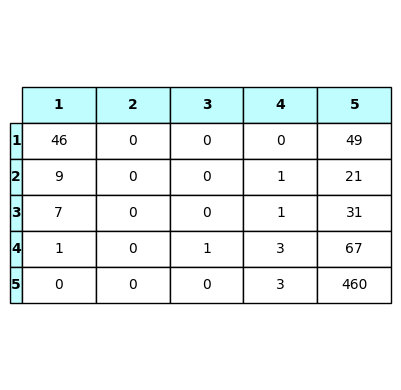


Displaying Classification Report:


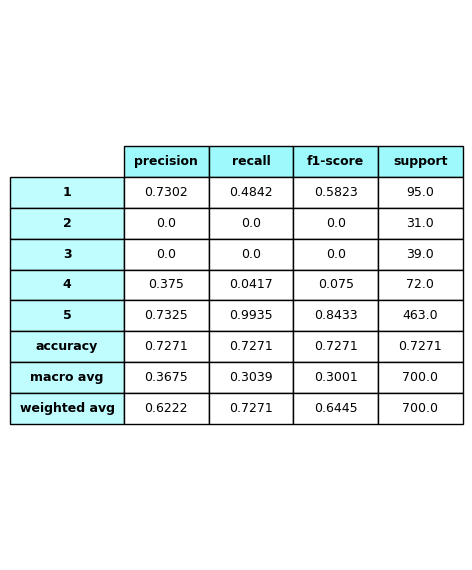


Model saved to gdrive/MyDrive/./CE807-25-SU/Assignment/model/logistic_regression_bert/model.sav


In [46]:
report_2 = train_2(train_file, val_file, MODEL_2_DIRECTORY)

## 3.3. Testing Method 2 Code
  

In [47]:
# Your Code(s)
def test_2(test_file, model_file, output_dir):
    """
    Loads a saved text classification model, predicts labels for a tokenized test dataset,
    and saves the predictions back into the original test CSV file.

    Args:
        test_file (str): Path to the test dataset CSV file.
        model_file (str): Filename of the saved (pickled) model (e.g., 'model.sav').
        output_dir (str): Path to the directory containing the saved model.

    Returns:
        None

    Notes:
        - The output predictions are remapped to 1–5 and saved under the
        column `out_label_model_2`.
        - The updated CSV file will overwrite the original test file.
    """
    # Read testing set data
    test_df = pd.read_csv(test_file)

    # Tokenize
    X_test = tokenize(test_df["text"], tokenizer)

    # Load saved logistic regression model
    model_path = os.path.join(output_dir, model_file)
    classifier = pickle.load(open(model_path, 'rb'))
    print('Model loaded from', model_path)

    # Predict (returns 0–4 labels)
    print('Testing on testing set')
    preds = classifier.predict(X_test)

    # Convert predictions from 0–4 to 1–5
    test_preds = (preds + 1).tolist()

    # Save predictions to the same directory as the model
    output_path = os.path.join(os.path.dirname(model_path), 'test_2_output.csv')
    pd.DataFrame({'out_label_model_2': test_preds}).to_csv(output_path, index=False)
    print('Predictions saved to', output_path)

    # Save predictions
    test_df['out_label_model_2'] = test_preds
    test_df.to_csv(test_file, index=False)
    print('Predictions added/updated to', test_file)

In [48]:
test_2(test_file, 'model.sav', MODEL_2_DIRECTORY)

Model loaded from gdrive/MyDrive/./CE807-25-SU/Assignment/model/logistic_regression_bert/model.sav
Testing on testing set
Predictions saved to gdrive/MyDrive/./CE807-25-SU/Assignment/model/logistic_regression_bert/test_2_output.csv
Predictions added/updated to gdrive/MyDrive/./CE807-25-SU/Assignment/data/test.csv


## Method 2 End


# 4 . Other Method/model Start



## 4.1. Summary Table and Pie Chart for the Datasets

> **Source**: The pie chart implementation was based on the official Matplotlib example: "*Pie and Donut Charts with Labels*", available at [https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html](https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html). Accessed on July 17, 2025.


,Dataset,Total (Number of samples)
0,Train,4914
1,Validation,700
2,Test,1386


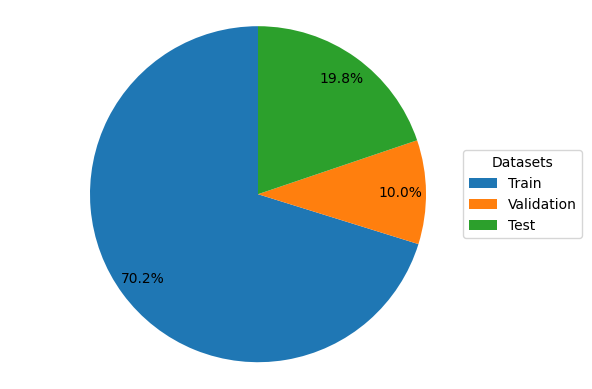

In [49]:
"""
Create the Summary Table and generate the Pie Chart
"""
summary_data = {
    'Dataset': ['Train', 'Validation', 'Test'],
    'Total (Number of samples)': [len(train_df), len(val_df), len(test_df)]
}

# Convert the dictionary to a pandas DataFrame
summary_df = pd.DataFrame(summary_data)
display(summary_df)


# Get labels and sizes from the summary table
labels = summary_df['Dataset']
sizes = summary_df['Total (Number of samples)']


# Pie chart code adapted from the Matplotlib example: "Pie and Donut Charts with Labels"
# https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html
# Accessed on July 17, 2025
fig, ax = plt.subplots()

# Generate the pie chart and get the 'wedges' for the legend
wedges, texts, autotexts = ax.pie(
    sizes,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85
)

# Ensure the pie is a circle
ax.axis('equal')

# Add the legend
ax.legend(
    wedges,
    labels,
    title="Datasets",
    loc="center left",
    bbox_to_anchor=(0.9, 0, 0.5, 1) # Position legend outside the chart
)

#plt.title("Dataset Distribution")
plt.show()

## 4.2. Summary Table for Review Ratings

> **Source**: The code for generating a Matplotlib table with highlights was adapted from "*Matplotlib Table Tutorial*" on Python Fiddle: [https://python-fiddle.com/tutorials/matplotlib-table](https://python-fiddle.com/tutorials/matplotlib-table). Accessed on July 17, 2025.


In [50]:
# Your Code(s)
"""
Generate a table for each dataset and its compositions
"""
# SET THE DESIRED DATASET FOR TABLE AND CHART GENERATION
table_df = val_df

# Add word count column
table_df["word_count"] = table_df["text"].str.split().str.len()

# Group by rating
result_df = table_df.groupby("rating").agg(
    number_of_reviews=("text", "count"),
    average_length_words=("word_count", "mean")
).reset_index()

# Round for readability
result_df["average_length_words"] = result_df["average_length_words"].round(2)

# Rename columns for nicer display
result_df = result_df.rename(columns={
    "rating": "Rating",
    "number_of_reviews": "Number of Reviews",
    "average_length_words": "Average Length (Words)"
})

# Create the totals row
total_reviews = result_df["Number of Reviews"].sum()
total_row = pd.DataFrame({
    "Rating": ["TOTAL"],
    "Number of Reviews": [total_reviews],
    #"Average Length (Words)": [0]
})

# Append totals row
result_df_with_total = pd.concat([result_df, total_row], ignore_index=True)

# Table with highlights adapted from: "Matplotlib Table Tutorial", Python Fiddle
# https://python-fiddle.com/tutorials/matplotlib-table
# Accessed on July 17, 2025
styled_table = (
    result_df_with_total.style
    .background_gradient(cmap="Blues", subset=["Number of Reviews"])
    .bar(subset=["Average Length (Words)"], color="#FFA07A")
    .set_properties(**{
        'border': '1px solid black',
        'font-size': '14px',
        'text-align': 'center'
    })
    .set_table_styles([
        {
            'selector': 'th',
            'props': [('background-color', '#40466e'),
                      ('color', 'white'),
                      ('font-weight', 'bold')]
        },
        {
            'selector': 'td',
            'props': [('padding', '8px')]
        }
    ])
    .format({"Average Length (Words)": "{:.2f}"})
)

# Display in notebook
styled_table

,Rating,Number of Reviews,Average Length (Words)
0,1,95,51.34
1,2,31,44.84
2,3,39,50.62
3,4,72,45.69
4,5,463,39.01
5,TOTAL,700,nan


## 4.3. Pie Chart for Review Ratings

> **Source**: The pie chart implementation was based on the official Matplotlib example: "*Pie and Donut Charts with Labels*", available at [https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html](https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html). Accessed on July 17, 2025.

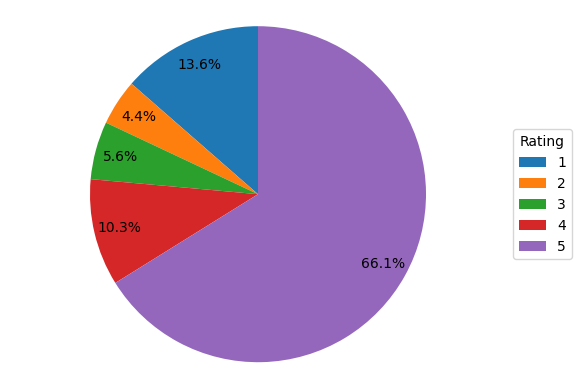

In [51]:
"""
Generate a pie chart showing the percentage of reviews by rating
"""
labels = result_df["Rating"]
sizes = result_df["Number of Reviews"]

# Pie chart code adapted from the Matplotlib example: "Pie and Donut Charts with Labels"
# https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html
# Accessed on July 17, 2025
fig, ax = plt.subplots()

# Generate the pie chart and get the 'wedges' for the legend
wedges, texts, autotexts = ax.pie(
    sizes,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85
)

# Ensure the pie chart is a circle
ax.axis('equal')

# Add the legend
ax.legend(
    wedges,
    labels,
    title="Rating",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

#plt.title("Percentage of Reviews by Rating")
plt.show()

## 4.4. Model Result Table

In [52]:
# Extract the metrics
model_data = [
    {
        "Model": "Model 1",
        "Accuracy": report_1.loc["accuracy", "support"],
        "F1 Score": report_1.loc["weighted avg", "f1-score"]
    },
    {
        "Model": "Model 2",
        "Accuracy": report_2.loc["accuracy", "support"],
        "F1 Score": report_2.loc["weighted avg", "f1-score"]
    }
]

comparison_df = pd.DataFrame(model_data).round(4)
display(comparison_df)

,Model,Accuracy,F1 Score
0,Model 1,0.7171,0.6324
1,Model 2,0.7271,0.6445


## 4.5. Predict Ratings on selected Validation data

> **Source**: The code for generating a Matplotlib table with highlights was adapted from "*Matplotlib Table Tutorial*" on Python Fiddle: [https://python-fiddle.com/tutorials/matplotlib-table](https://python-fiddle.com/tutorials/matplotlib-table). Accessed on July 19, 2025.

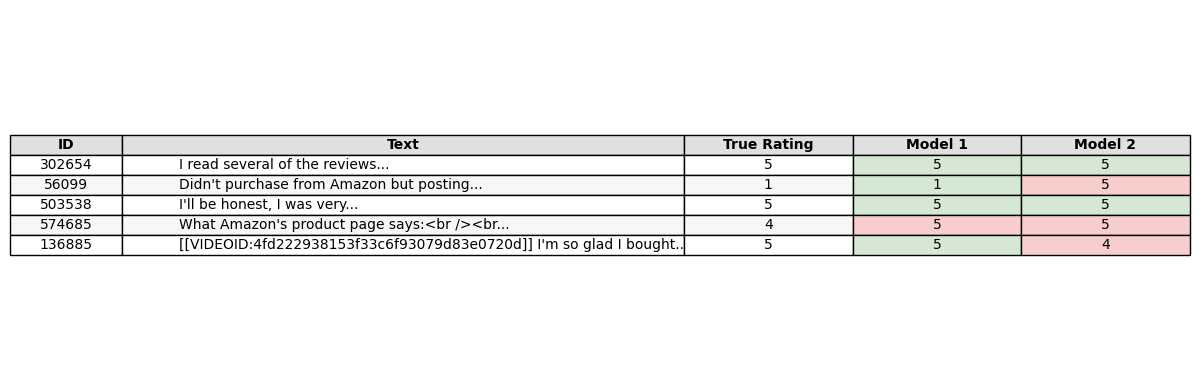

In [53]:
# Create a test_df based on selected rows from earlier table
selected_ids = [136885, 503538, 574685, 302654, 56099]
selected_val_df = val_df[val_df['id'].isin(selected_ids)][['id', 'text', 'rating']].copy()

# Load model 1 and predict
model1_path = os.path.join(MODEL_1_DIRECTORY, 'model.sav')
model1 = pickle.load(open(model1_path, 'rb'))
selected_val_df['Model 1'] = model1.predict(selected_val_df['text'])

# Load model 2 and predict
X_test = tokenize(selected_val_df['text'], tokenizer)
model2_path = os.path.join(MODEL_2_DIRECTORY, 'model.sav')
model2 = pickle.load(open(model2_path, 'rb'))
model2_preds = model2.predict(X_test)
selected_val_df['Model 2'] = (model2_preds + 1).tolist()

# Rename columns for final output
selected_val_df.rename(columns={'id': 'ID', 'text': 'Text', 'rating': 'True Rating'}, inplace=True)
final_df = selected_val_df[['ID', 'Text', 'True Rating', 'Model 1', 'Model 2']]

# Prevents text from overflowing the cell
def truncate_text(text, num_words=6):
    """Truncates text to a specified number of words and adds '...'."""
    words = text.split()
    if len(words) > num_words:
        return ' '.join(words[:num_words]) + '...'
    return text

df_plot = final_df.copy()
df_plot['Text'] = df_plot['Text'].apply(truncate_text)

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off')
ax.axis('tight')

# Create the table
the_table = ax.table(
    cellText=df_plot.values,
    colLabels=df_plot.columns,
    loc='center',
    cellLoc='center'
)

# Style the table
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

# Define colors and column widths
col_widths = [0.1, 0.5, 0.15, 0.15, 0.15]
correct_color = '#D5E8D4' # Light Green
incorrect_color = '#F8CECC' # Light Red

for (row, col), cell in the_table.get_celld().items():
    # Set the width of each column
    cell.set_width(col_widths[col])

    # Style header row
    if row == 0:
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#E0E0E0')
        continue

    # Conditional highlighting logic
    # Check if the column is Model 1 or Model 2
    if col in [3, 4]:
        true_rating = final_df.iloc[row-1, 2] # Get true rating from the original df
        predicted_rating = final_df.iloc[row-1, col] # Get predicted rating

        if predicted_rating == true_rating:
            cell.set_facecolor(correct_color)
        else:
            cell.set_facecolor(incorrect_color)
    else:
        if row % 2 == 0:
            cell.set_facecolor('#F7F7F7')
        else:
            cell.set_facecolor('#FFFFFF')
    if col == 1:
            cell.set_text_props(ha='left')

fig.tight_layout()
plt.show()

##Other Method/model End

In [54]:
train_df[train_df['rating'] == 5]['text'].values[7]

'Seems to be correct part and works as it should'

In [55]:
data_1 = train_df['text'][58]
data_1

"Like many, I bought this because I live in an apartment with no washer or dryer. Overall, I like it for what it is. However, potential buyers need to keep in mind that they aren't purchasing a fancy washer/dryer- this really can't take the place of a proper set up. For perspective, I use this to wash items that cant wait for me to get to the laundromat and baby clothes.<br /><br />Here are some things to keep in mind with this item, and honestly others like it (as I don't think it's a brand/quality issue so much as a limitation of this product in general type scenario):<br /><br />1. To drain the water after rinsing, the hose uses gravity. This means the drain needs at the base or below the washing machine to work. Don't attempt to pick this machine up while full of water. To deal with this, I put this machine in my bathtub while in use.<br /><br />2. These aren't sturdy items. It is best to have it on the ground rather than on some sort of cart to drain into a sink, if you're thinkin

In [56]:
prepared_text = preprocessing_stage(data_1)
prepared_text

"like many, i bought this because i live in an apartment with no washer or dryer. overall, i like it for what it is. however, potential buyers need to keep in mind that they aren't purchasing a fancy washer/dryer- this really can't take the place of a proper set up. for perspective, i use this to wash items that cant wait for me to get to the laundromat and baby clothes. here are some things to keep in mind with this item, and honestly others like it (as i don't think it's a brand/quality issue so much as a limitation of this product in general type scenario): 1. to drain the water after rinsing, the hose uses gravity. this means the drain needs at the base or below the washing machine to work. don't attempt to pick this machine up while full of water. to deal with this, i put this machine in my bathtub while in use. 2. these aren't sturdy items. it is best to have it on the ground rather than on some sort of cart to drain into a sink, if you're thinking of trying that. they also becom